In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from itertools import combinations
from collections import Counter
import textwrap

In [43]:
# Read the CSV file
df = pd.read_csv('final_all_european_players.csv')

In [45]:
# Generate unique player identifiers
df['PlayerID'] = list(zip(df['Player'], df['Born']))

# Group player IDs by squad
squad_to_players = df.groupby('Squad')['PlayerID'].apply(set)

# Create team-to-league mapping
team_league_map = (
    df.dropna(subset=['Squad', 'League'])
      .drop_duplicates(subset=['Squad'])
      .set_index('Squad')['League']
      .to_dict()
)

# Calculate shared players and associated leagues
records = []
for squad1, squad2 in combinations(squad_to_players.index, 2):
    shared_players = squad_to_players[squad1] & squad_to_players[squad2]
    if not shared_players:
        continue
    league1 = team_league_map.get(squad1)
    league2 = team_league_map.get(squad2)
    league = league1 if league1 == league2 else 'International' if league1 and league2 else 'Unknown'
    records.append({
        'Team1': squad1,
        'Team2': squad2,
        'SharedPlayers': len(shared_players),
        'League': league
    })

# Build and process dataframe
overlap_df = pd.DataFrame(records).sort_values(by='SharedPlayers', ascending=False).reset_index(drop=True)

In [47]:
# Create the Rank column based on SharedPlayers ranking
overlap_df['Rank'] = overlap_df['SharedPlayers'].rank(method='min', ascending=False).astype(int)

# Adjust the rank to display with suffixes
def add_rank_suffix(rank):
    if 10 <= rank % 100 <= 20:  # Handles 11th, 12th, 13th, etc.
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(rank % 10, 'th')
    return f"{rank}{suffix}"

# Apply the function to the 'Rank' column
overlap_df['Rank'] = overlap_df['Rank'].apply(add_rank_suffix)

# Set the index to start from 1
overlap_df.index = range(1, len(overlap_df) + 1)

# Reorder columns so 'Rank' is the first column
overlap_df = overlap_df[['Rank'] + [col for col in overlap_df.columns if col != 'Rank']]

# Set max rows to display
pd.set_option('display.max_rows', 150)

# Display the DataFrame
overlap_df.head(100)


,Rank,Team1,Team2,SharedPlayers,League
1,1st,Parma,Sampdoria,41,Serie A
2,2nd,Fiorentina,Genoa,40,Serie A
3,2nd,Inter,Parma,40,Serie A
4,4th,Atalanta,Bologna,38,Serie A
5,4th,Fiorentina,Juventus,38,Serie A
6,4th,Parma,Torino,38,Serie A
7,7th,Inter,Roma,37,Serie A
8,7th,Atalanta,Cagliari,37,Serie A
9,9th,Atalanta,Sampdoria,36,Serie A
10,9th,Atalanta,Torino,36,Serie A


/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_19908/3780024420.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['1st', '22nd', '22nd', '68th', '86th', '97th'])


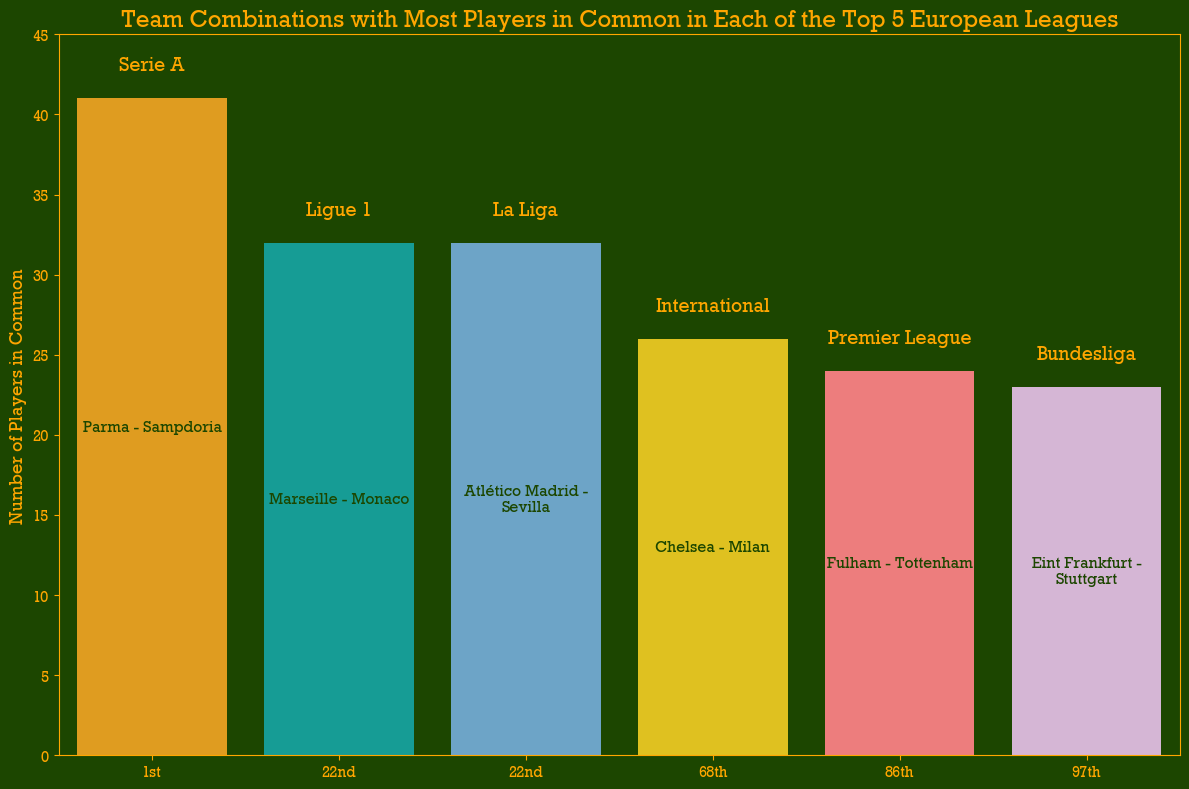

In [49]:
# Top 1 per league
top_1_per_league = overlap_df.groupby('League').head(1).reset_index(drop=True)
top_1_per_league['TeamCombo'] = top_1_per_league['Team1'] + ' - ' + top_1_per_league['Team2']
top_1_per_league['RankLabel'] = [f"{i+1}{'st' if i == 0 else 'nd' if i == 1 else 'rd' if i == 2 else 'th'}" for i in range(len(top_1_per_league))]

# Plot configuration
plt.rcParams['font.family'] = 'Rockwell'
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('#1c4600')
ax.set_facecolor('#1c4600')

def wrap_label(text, width=20):
    return "\n".join(textwrap.wrap(text, width))

# Color palette
custom_palette = {
    'Premier League': '#FF6B6B',
    'La Liga': '#5EA8D6',
    'Bundesliga': '#DAB1DA',
    'Serie A': '#ffa600',
    'Ligue 1': '#00B2A9',
    'International': '#FFD700',
    'Unknown': '#AAAAAA'
}

# Draw bars
sns.barplot(
    data=top_1_per_league,
    x='RankLabel',
    y='SharedPlayers',
    hue='League',
    palette=custom_palette,
    ax=ax
)

# Annotate bars with League and TeamCombo
for i, row in top_1_per_league.iterrows():
    # Inside the bar: team combination
    ax.text(
        i,
        row['SharedPlayers'] / 2,
        wrap_label(row['TeamCombo'], width=18),
        color='#1c4600',
        fontsize=10.5,
        fontweight='bold',
        ha='center',
        va='center'
    )
    
    # Above the bar: league label
    ax.text(
        i,
        row['SharedPlayers'] + 1.5,
        row['League'],
        color='#ffa600',
        fontsize=13,
        ha='center',
        va='bottom'
    )

# Customize chart
ax.set_title('Team Combinations with Most Players in Common in Each of the Top 5 European Leagues', fontsize=16, color='#ffa600')
ax.set_ylabel('Number of Players in Common', fontsize=12, color='#ffa600')
ax.set_xlabel('')  # Remove x-axis label

ax.set_xticklabels(['1st', '22nd', '22nd', '68th', '86th', '97th'])
ax.set_ylim(0, 45)

# Axis styling
ax.tick_params(axis='x', labelsize=10, labelcolor='#ffa600', colors='#ffa600')
ax.tick_params(axis='y', labelsize=10, labelcolor='#ffa600', colors='#ffa600')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#ffa600')

# Remove legend
ax.get_legend().remove()

# Final layout
plt.tight_layout()
plt.show()


/var/folders/q_/3dw4jg3d1zg1vtq9c1d082h00000gn/T/ipykernel_19908/4172297007.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Color'] = filtered.apply(assign_color, axis=1)


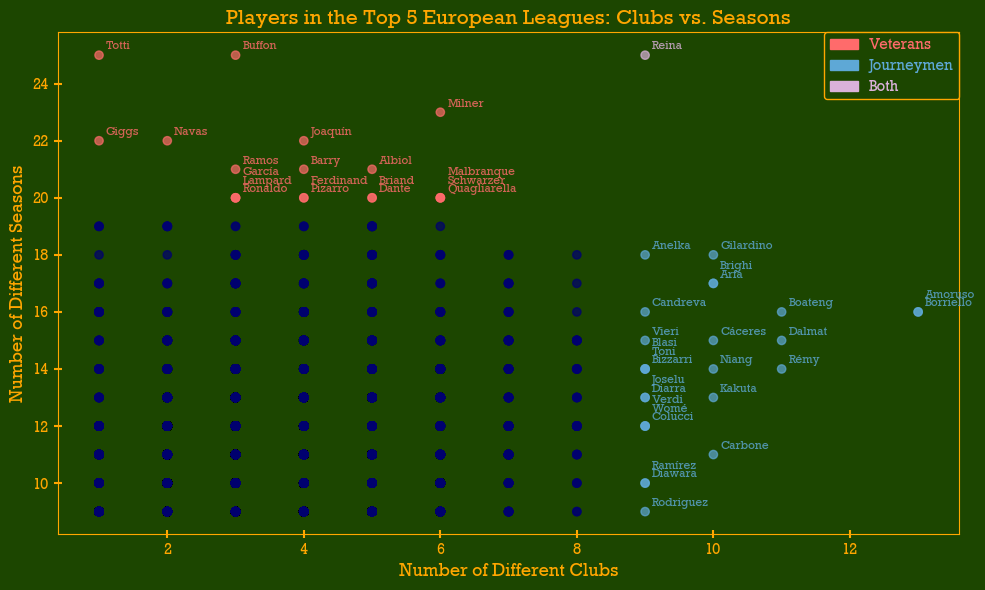

In [51]:


# --- Setup ---

# Assign unique PlayerID using name and birth year
df['PlayerID'] = list(zip(df['Player'], df['Born']))

# Aggregate player career stats
player_stats = df.groupby('PlayerID').agg(
    NumClubs=('Squad', 'nunique'),
    NumSeasons=('Season', 'nunique'),
    PlayerName=('Player', 'first')
).reset_index()

# Extract surname for labeling
player_stats['Surname'] = player_stats['PlayerName'].str.split().str[-1]

# Filter players with more than 8 seasons
filtered = player_stats[player_stats['NumSeasons'] > 8]

# --- Plot Config ---

plt.rcParams['font.family'] = 'Rockwell'
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1c4600')
ax.set_facecolor('#1c4600')

# Define color coding
def assign_color(row):
    if row['NumSeasons'] > 19 and row['NumClubs'] > 8:
        return '#DAB1DA'  # Both
    elif row['NumSeasons'] > 19:
        return '#FF6B6B'  # Veterans
    elif row['NumClubs'] > 8:
        return '#5EA8D6'  # Journeymen
    return '#000070'      # Default

filtered['Color'] = filtered.apply(assign_color, axis=1)

# Plot scatter
ax.scatter(filtered['NumClubs'], filtered['NumSeasons'], c=filtered['Color'], alpha=0.7)

# Offset duplicate labels
label_offset = defaultdict(int)

# Add labels for highlighted players
for _, row in filtered.iterrows():
    if row['Color'] != '#000070':
        pos = (row['NumClubs'], row['NumSeasons'])
        offset = 0.2 + label_offset[pos] * 0.3
        ax.text(
            row['NumClubs'] + 0.1,
            row['NumSeasons'] + offset,
            row['Surname'],
            fontsize=8,
            alpha=0.8,
            color=row['Color']
        )
        label_offset[pos] += 1

# --- Axis & Title ---

ax.set_title("Players in the Top 5 European Leagues: Clubs vs. Seasons", fontsize=14, color='#ffa600')
ax.set_xlabel("Number of Different Clubs", fontsize=12, color='#ffa600')
ax.set_ylabel("Number of Different Seasons", fontsize=12, color='#ffa600')

# Style ticks
ax.tick_params(axis='both', labelsize=10, labelcolor='#ffa600', colors='#ffa600',
               direction='inout', length=6, width=1.5)

# Style axis borders
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#ffa600')

# --- Legend ---

legend_elements = [
    mpatches.Patch(color='#FF6B6B', label='Veterans'),
    mpatches.Patch(color='#5EA8D6', label='Journeymen'),
    mpatches.Patch(color='#DAB1DA', label='Both'),
]

legend = ax.legend(handles=legend_elements, loc='upper right',
                   fontsize=10, facecolor='#1c4600', edgecolor='#ffa600',
                   bbox_to_anchor=(1.008, 1.014), framealpha=1)

for patch, color in zip(legend.get_texts(), ['#FF6B6B', '#5EA8D6', '#DAB1DA']):
    patch.set_color(color)

# --- Final Display ---

plt.tight_layout()
plt.show()